In [296]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#Library for Modelling 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

#Library for Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

%matplotlib inline

# Data Manipulation

In [297]:
#Loading data into training and testing sets
train_data=pd.read_csv('competitive-data-science-predict-future-sales/sales_train.csv')

In [298]:
#Displaying Training Data
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


**Preparing Training Data**

In [299]:
#Displaying Metadata/Information about Training Data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [300]:
#Displaying Stats on Training Data
train_data.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


Here, it could be noticed that item_price and item_cnt_day consist of Negative Numbers. These values should be changed into positive because as the value is in negative it does not make any sense, item price being in negative.

In [301]:
#Changing Negative numbers into Positive
train_data['item_price']=train_data['item_price'].abs()
train_data['item_cnt_day']=train_data['item_cnt_day'].abs()

In [302]:
#Checking if the training data has any Null values or not
null_percent=100*(train_data.isnull().sum()/len(train_data))
print(null_percent)

date              0.0
date_block_num    0.0
shop_id           0.0
item_id           0.0
item_price        0.0
item_cnt_day      0.0
dtype: float64


As the item count per month is to be predicted, item_cnt_day will be converted to item_cnt_mnt

In [303]:
#Grouping item price and item count per month
train_data=train_data.groupby(['date_block_num','shop_id','item_id']).agg({'item_price':'last','item_cnt_day':'sum'}).reset_index()

#Changing the name of the item_cnt_day to item_cnt_month
train_data=train_data.rename(columns={'item_cnt_day':'item_cnt_month'})
print(train_data)

         date_block_num  shop_id  item_id  item_price  item_cnt_month
0                     0        0       32       221.0             6.0
1                     0        0       33       347.0             3.0
2                     0        0       35       247.0             1.0
3                     0        0       43       221.0             1.0
4                     0        0       51       127.0             2.0
...                 ...      ...      ...         ...             ...
1609119              33       59    22087       119.0             6.0
1609120              33       59    22088       119.0             2.0
1609121              33       59    22091       179.0             1.0
1609122              33       59    22100       629.0             1.0
1609123              33       59    22102      1250.0             1.0

[1609124 rows x 5 columns]


**Correlation is a good way to find whether the data columns have linear relationship with item_cnt_day or not. If the correlation value is closer to one, then the data columns are positively related.**

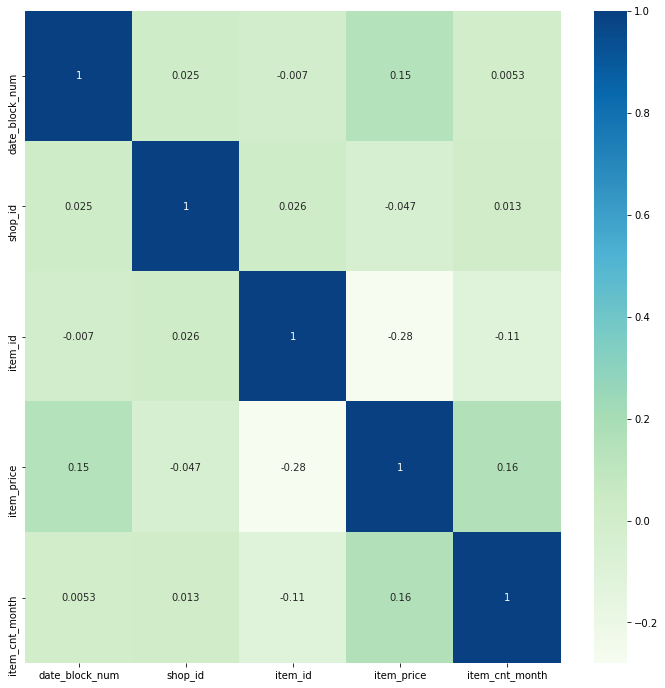

In [304]:
#Calculating Correlation
correlation=train_data.corr(method='spearman')    ### diff. corelation methods - pearson, kendall

#Plotting correlation
plt.figure(figsize=(12,12))
corr_heatmap=sns.heatmap(correlation,annot=True,cmap="GnBu")

In [305]:
train_data

,date_block_num,shop_id,item_id,item_price,item_cnt_month
0,0,0,32,221.0,6.0
1,0,0,33,347.0,3.0
2,0,0,35,247.0,1.0
3,0,0,43,221.0,1.0
4,0,0,51,127.0,2.0
...,...,...,...,...,...
1609119,33,59,22087,119.0,6.0
1609120,33,59,22088,119.0,2.0
1609121,33,59,22091,179.0,1.0
1609122,33,59,22100,629.0,1.0


# Outliers

/home/kalaiselvan/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='item_cnt_month'>

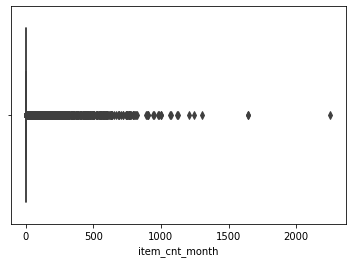

In [306]:
sns.boxplot(train_data["item_cnt_month"])

date_block_num


/home/kalaiselvan/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


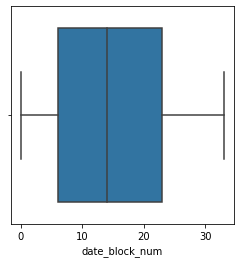

shop_id


/home/kalaiselvan/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


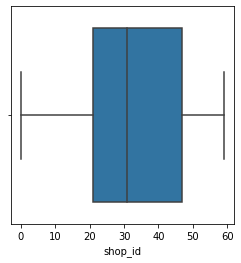

item_id


/home/kalaiselvan/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


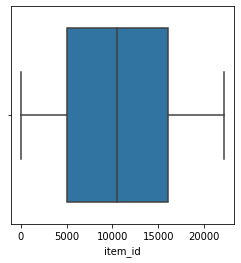

item_price


/home/kalaiselvan/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


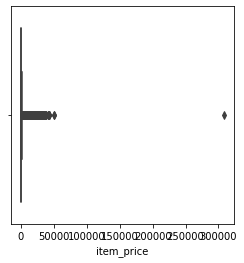

item_cnt_month


/home/kalaiselvan/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


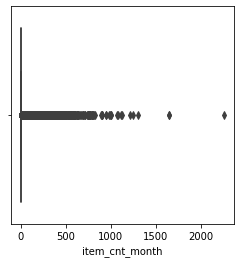

In [307]:
for feature in train_data.columns:
    print(feature)
    plt.figure(figsize=(4,4))
    sns.boxplot(train_data[feature])
    plt.show()

# Skewness

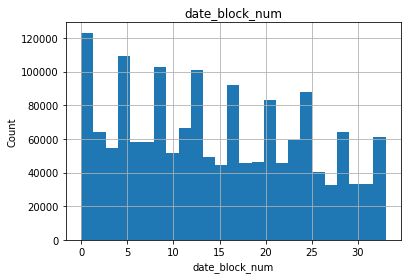

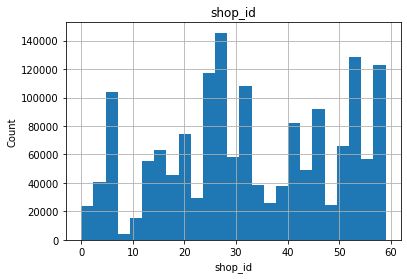

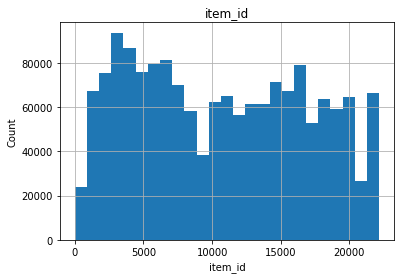

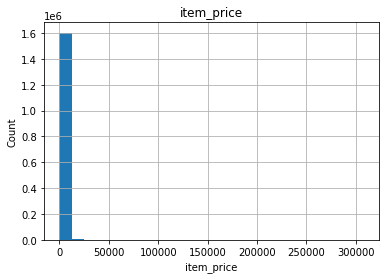

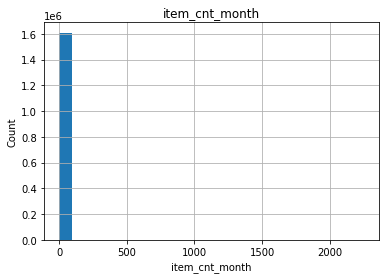

In [308]:
for feature in train_data.columns:
    train_data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

In [309]:
for feature in train_data.columns:
    if 0 in train_data[feature].unique():
        pass
    else:
        print(feature)
        train_data[feature]=np.log(train_data[feature])

item_price
item_cnt_month


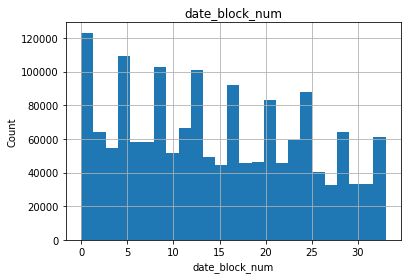

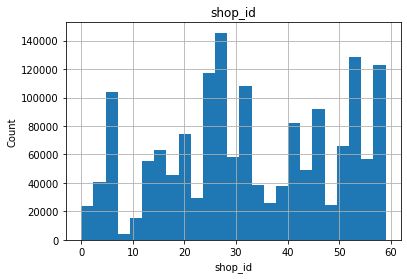

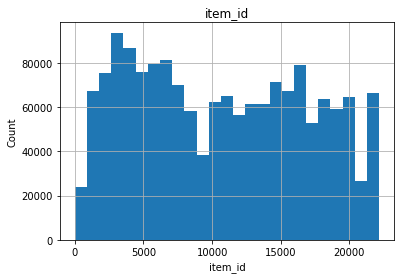

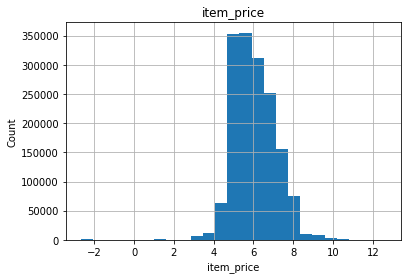

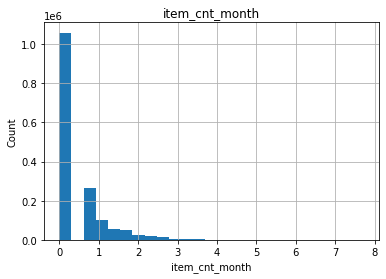

In [310]:
for feature in train_data.columns:
    train_data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

# Preparing Test Data

In [311]:
test_data=pd.read_csv('competitive-data-science-predict-future-sales/test.csv')

test_data.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


As Test data only consists of two data columns shop_id and item_id, other data columns like date_block_num and item price should be added.

In [312]:
date_block_num = pd.read_csv("predicted/date_block_num.csv")
item_price = pd.read_csv("predicted/item_price.csv")

In [313]:
#Adding date_block_num to the Test data

# test_data['date_block_num']=34
# test_data=test_data[['date_block_num','shop_id','item_id']]
test_data = test_data.join(date_block_num)
test_data.head()

,ID,shop_id,item_id,predicted_date_block_num
0,0,5,5037,-1.060742
1,1,5,5320,-0.328165
2,2,5,5233,-1.422938
3,3,5,5232,-1.456473
4,4,5,5268,1.177408


In [314]:
test_data = test_data.join(item_price)
test_data.head()

,ID,shop_id,item_id,predicted_date_block_num,predicted_item_price
0,0,5,5037,-1.060742,-1.638633
1,1,5,5320,-0.328165,-0.755100
2,2,5,5233,-1.422938,0.056104
3,3,5,5232,-1.456473,0.093423
4,4,5,5268,1.177408,-0.078412


In [315]:
test_data = test_data.drop(labels = ["ID"],axis=1)

In [316]:
# #Adding the latest item price from the training data into test data into their respective item id

# item_price=dict(train_data.groupby('item_id')['item_price'].last().reset_index().values)
# test_data['item_price']=test_data.item_id.map(item_price)
# test_data.head()

In [317]:
test_data.shape

(214200, 4)

In [318]:
test_data.isnull().sum()

shop_id                     0
item_id                     0
predicted_date_block_num    0
predicted_item_price        0
dtype: int64

In [319]:
#Replacing Missing Value with median price

# test_data['predicted_item_price']=test_data['predicted_item_price'].fillna(test_data['predicted_item_price'].median())

In [320]:
# test_data.isnull().sum()

In [321]:
# for feature in test_data.columns:
#     if 0 in test_data[feature].unique():
#         pass
#     else:
#         print(feature)
#         test_data[feature]=np.log(test_data[feature])

In [322]:
# test_data['item_price']=test_data['item_price'].fillna(test_data['item_price'].median())

In [323]:
test_data.isnull().sum()

shop_id                     0
item_id                     0
predicted_date_block_num    0
predicted_item_price        0
dtype: int64

# Preparing for Modelling

In [324]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(train_data)

train_data = pd.DataFrame(scaler.transform(train_data), columns = train_data.columns)

train_data.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_month
0,-1.536816,-1.983784,-1.706875,-0.649855,2.059322
1,-1.536816,-1.983784,-1.706715,-0.213787,1.032998
2,-1.536816,-1.983784,-1.706394,-0.542350,-0.593688
3,-1.536816,-1.983784,-1.705112,-0.649855,-0.593688
4,-1.536816,-1.983784,-1.703830,-1.185296,0.432636


In [325]:
test_data.isnull().sum()

shop_id                     0
item_id                     0
predicted_date_block_num    0
predicted_item_price        0
dtype: int64

In [326]:
scaler.fit(test_data)

test_data = pd.DataFrame(scaler.transform(test_data), columns = test_data.columns)

test_data.isnull().sum()

shop_id                     0
item_id                     0
predicted_date_block_num    0
predicted_item_price        0
dtype: int64

In [327]:
#allocating training data into X and y training sets
x_train = train_data.drop('item_cnt_month',axis=1)
y_train = train_data["item_cnt_month"]
x_test = test_data
x_train.shape,y_train.shape

((1609124, 4), (1609124,))

In [328]:
x_test.isnull().sum()

shop_id                     0
item_id                     0
predicted_date_block_num    0
predicted_item_price        0
dtype: int64

# Training the Model

**Linear Regression**

In [329]:
#Training the model
linear_model=LinearRegression(n_jobs=10)
linear_model.fit(x_train,y_train)

#Testing the model
linear_prediction=linear_model.predict(x_test)

#output is the predicted cnt_per_month
print(linear_prediction)

[-0.05869051 -0.03171062  0.13367872 ... -0.18228539  0.07271216
  0.15938071]


In [330]:
# val.to_csv("predicted/sample_submission.csv", header = ["item_cnt_month"], index=False)

**Random Forest Regression**

In [331]:
# #Buliding Model in Random Forest Regressor
# rr_model=RandomForestRegressor(n_estimators=10)
# rr_model.fit(x_train,y_train)

In [332]:
# # Testing the model
# rr_predict=rr_model.predict(x_test)
# print(rr_predict)

**Lasso Regression**

In [333]:
# #Building the Model in Lasso Regression Model
# lasso_model=Lasso(alpha=1.0)
# lasso_model.fit(x_train,y_train)

# #Testing the Model
# lasso_predict=lasso_model.predict(x_test)
# print(lasso_predict)

**Ridge Regression**

In [334]:
# #Building the model in Ridge Regression Model
# r_model=Ridge(alpha=1.0)
# r_model.fit(x_train,y_train)

# #Testing the model
# r_predict=r_model.predict(x_test)
# print(r_predict)

# Saving the Output in CSV file

In [335]:
# #Creating Dataframe to Display the output, The Id is the item id from the test data and output is the predicted cnt_per_month

# sample_submission= pd.read_csv("competitive-data-science-predict-future-sales/sample_submission.csv")
# sample_submission.item_cnt_month=linear_prediction
# linear_result=sample_submission
# print(linear_result)

In [336]:
# linear_result.to_csv("sample_submission.csv",index=False)
# print("Completed")